# Predicting Coffee Prices Using Random Forest Regression

Temperature and production data were combined into a random forest

# Part I: Code

### Import libraries

In [1]:
# Preprocessed data
from capstone_modules import Production_Data, Temperature_Data, ICO_Composite_Indicator

# Analysis
import numpy as np
import pandas as pd

# Modeling and statistics
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### Import data

In [2]:
master_dataframe = pd.DataFrame()

# Import production data
production = Production_Data()
ICO_categories = production.ICO_categories
for category in ICO_categories:
    temp_df = production.get_aggregate_production_data_by_ICO_category(category)
    temp_df.name = category + " Production"
    master_dataframe = pd.concat([master_dataframe, temp_df], axis = 1)

# Import ICO composite indicator index data
ICO_composite_indicator = ICO_Composite_Indicator().ICO_indicator_data[["ICO Composite Indicator"]]
    
# Import temperature data
temperature = Temperature_Data()

# Convert master_dataframe to a time series

master_dataframe.index = pd.to_datetime(master_dataframe.index, format = "%Y").values
master_dataframe = master_dataframe.resample("M").bfill()

master_dataframe = ICO_composite_indicator.merge(master_dataframe, left_index = True, right_index = True)

In [3]:
def figure_coffee_production_for_each_ICO_category():
    legend_list = list()
    for category in ICO_categories:
        temp_df = production.get_aggregate_production_data_by_ICO_category(category)
        temp_df.plot()

    plt.title("Coffee production for each ICO category")
    plt.xlabel("Production year")
    plt.ylabel("Green coffee production (60 kg bags)")

    plt.legend(["Brazilian Naturals", "Colombian Milds", "Other Milds", "Robustas"], loc = 'best')
    plt.show()
    

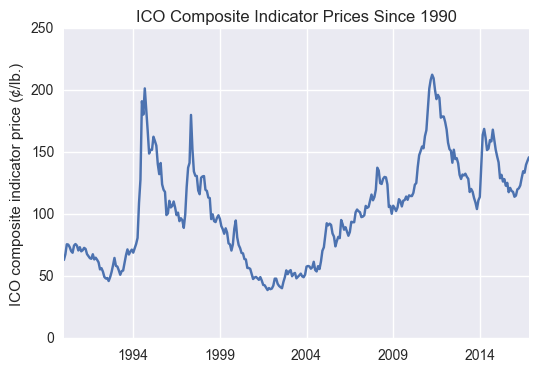

In [4]:
def figure_ICO_composite_indicator_since_1960():
    total_ICO_composite_indicator = pd.read_csv("../datasets/capstone/ICO composite indicator index since 1960.csv")
    total_ICO_composite_indicator.index = pd.to_datetime(total_ICO_composite_indicator["Unnamed: 0"].values, errors = 'coerce')
    total_ICO_composite_indicator = total_ICO_composite_indicator.drop("Unnamed: 0", axis = 1)
    total_ICO_composite_indicator.columns = ["ICO composite indicator price (¢/lb.)"]

    total_ICO_composite_indicator.plot()
    plt.title("ICO Composite Indicator Prices Since 1960")
    plt.ylabel("ICO composite indicator price (¢/lb.)")
    plt.legend("")
    plt.show()

def figure_ICO_composite_indicator_since_1990():
    total_ICO_composite_indicator = pd.read_csv("../datasets/capstone/ICO composite indicator index since 1960.csv")
    total_ICO_composite_indicator.index = pd.to_datetime(total_ICO_composite_indicator["Unnamed: 0"].values, errors = 'coerce')
    total_ICO_composite_indicator = total_ICO_composite_indicator.drop("Unnamed: 0", axis = 1)
    total_ICO_composite_indicator.columns = ["ICO composite indicator price (¢/lb.)"]

    total_ICO_composite_indicator[total_ICO_composite_indicator.index.year > 1989].plot()
    plt.title("ICO Composite Indicator Prices Since 1990")
    plt.ylabel("ICO composite indicator price (¢/lb.)")
    plt.legend("")
    plt.show()
    
figure_ICO_composite_indicator_since_1990()

In [5]:
def figure_autocorrelation_of_ICO_composite_indicator():
    pd.tools.plotting.autocorrelation_plot(test_dataframe.iloc[:, 1].dropna())
    plt.title("Autocorrelation of ICO Composite Indicator")
    plt.xlabel("Lag time (months)")
    plt.show()


In [6]:
def figure_ICO_composite_indicator_modeled_by_ICO_categories():

    dataframe = ICO_Composite_Indicator().ICO_indicator_data[1:]
    
    X = dataframe.drop("ICO Composite Indicator", axis = 1)
    y = dataframe["ICO Composite Indicator"]
    
    train_X, test_X, train_y, test_y = train_test_split(X, y)

    linear_model = LinearRegression()
    linear_model.fit(train_X, train_y)
    
    plt.scatter(linear_model.predict(test_X), test_y)
    plt.plot([30,240], [30,240], "r--")
    plt.xlabel("Predicted ICO Composite Indicator values")
    plt.ylabel("Actual ICO Composite Indicator values")
    plt.title("Modeling ICO Composite Indicator from Category Prices")
    plt.legend("")
    plt.show()    
    

### Mapping temperature stations

In [7]:
def figure_map_of_weather_stations_in_coffee_producing_countries():
    
    coffee_harvest_schedule = pd.read_csv("../datasets/capstone/coffee harvest schedule.csv", index_col = 0)
    
    station_data = pd.read_csv("../datasets/capstone/downloaded data/berkeley_earth_stations--site_detail.txt", 
                               delimiter = "\t", 
                               skiprows =148, 
                               names = ["Station ID", 
                                        "Station Name", 
                                        "Latitude", 
                                        "Longitude", 
                                        "Elevation (m)", 
                                        "Lat. Uncertainty", 
                                        "Long. Uncertainty", 
                                        "Elev. Uncertainty (m)", 
                                        "Country", 
                                        "State / Province Code", 
                                        "County", 
                                        "Time Zone", 
                                        "WMO ID", 
                                        "Coop ID", 
                                        "WBAN ID", 
                                        "ICAO ID", 
                                        "# of Relocations", 
                                        "# Suggested Relocations", 
                                        "# of Sources", 
                                        "Hash"])

    # Select only relevant columns
    station_data = station_data[["Station ID", "Station Name", "Latitude", "Longitude", "Elevation (m)", "Lat. Uncertainty", "Long. Uncertainty", "Elev. Uncertainty (m)", "Country"]]

    # Convert values in numerical columns
    numeric_columns_in_stations_data = ["Latitude", "Longitude", "Elevation (m)", "Lat. Uncertainty", "Long. Uncertainty", "Elev. Uncertainty (m)"]
    station_data.loc[:, numeric_columns_in_stations_data] = station_data[numeric_columns_in_stations_data].apply(pd.to_numeric, errors = 'coerce')

    # Remove whitespace from non-numerical columns
    station_data.loc[:, "Station Name"] = station_data["Station Name"].str.strip()
    station_data.loc[:, "Country"] = station_data["Country"].str.strip()

    stations_in_coffee_producing_countries = station_data[station_data["Country"].isin(coffee_harvest_schedule["Producing Country"])]

    hemisphere_dictionary = (station_data.groupby(by = "Country")["Latitude"].mean() > 0).map({True: "Northern", False: "Southern"}).to_dict()

    
    # Arabica grows best in elevations 548 m – 1100 m for latitudes between 16° and 24°, or 1097 m – 1920 m for latitudes less that ±10°
    arabica_growing_conditions_criteria = (stations_in_coffee_producing_countries["Elevation (m)"] >= 548) & (stations_in_coffee_producing_countries["Elevation (m)"] <= 1100) & (stations_in_coffee_producing_countries["Latitude"].abs() > 16) & (stations_in_coffee_producing_countries["Latitude"].abs() <= 24)
    arabica_growing_conditions_criteria = arabica_growing_conditions_criteria | ((stations_in_coffee_producing_countries["Elevation (m)"] >= 1097) & (stations_in_coffee_producing_countries["Elevation (m)"] <= 1920) & (stations_in_coffee_producing_countries["Latitude"].abs() <= 10))

    # Robusta grows best in elevations 0 m – 914 m in latitudes between ±10°
    robusta_growing_conditions_criteria = (stations_in_coffee_producing_countries["Elevation (m)"] <= 914) & (stations_in_coffee_producing_countries["Latitude"].abs() <= 10)

    # Select the stations in the ideal coffee growing regions
    stations_in_arabica_conditions = stations_in_coffee_producing_countries[arabica_growing_conditions_criteria]["Station ID"]
    stations_in_robusta_conditions = stations_in_coffee_producing_countries[robusta_growing_conditions_criteria]["Station ID"]


    from mpl_toolkits.basemap import Basemap

    arabica_producing_locations = pd.DataFrame(stations_in_arabica_conditions).merge(stations_in_coffee_producing_countries[["Station ID", "Latitude", "Longitude"]], on = "Station ID")
    robusta_producing_locations = pd.DataFrame(stations_in_robusta_conditions).merge(stations_in_coffee_producing_countries[["Station ID", "Latitude", "Longitude"]], on = "Station ID")

    arabica_longitudes = arabica_producing_locations["Longitude"].tolist()
    arabica_latitudes = arabica_producing_locations["Latitude"].tolist()

    robusta_longitudes = robusta_producing_locations["Longitude"].tolist()
    robusta_latitudes = robusta_producing_locations["Latitude"].tolist()


    fig = plt.figure(figsize = (10,16))
    station_map = Basemap()

    arabica_x, arabica_y = station_map(arabica_longitudes, arabica_latitudes)
    station_map.scatter(arabica_x, arabica_y, color='b')

    robusta_x, robusta_y = station_map(robusta_longitudes, robusta_latitudes)
    station_map.scatter(robusta_x, robusta_y, color='r')


    station_map.drawcoastlines()
    station_map.drawcountries()

    plt.title("Stations in Berkeley Earth Data in Coffee Growing Conditions")
    plt.legend(["Arabica", "Robusta"], loc = 'center left')
    plt.show()


### Showing distribution of coffee production across countries

In [8]:
production_shares_by_type = production.get_production_share_by_country()[production.get_production_share_by_country()["Market_Year"] > 1989]\
    .pivot_table(values = ["Arabica Production Share", "Robusta Production Share"], index = ["Country"])

def figure_cumulative_production_shares_per_coffee_type_by_country():
    plt.plot(np.cumsum(production_shares_by_type.sort_values("Arabica Production Share", ascending = False)["Arabica Production Share"].values))
    plt.plot(np.cumsum(production_shares_by_type.sort_values("Robusta Production Share", ascending = False)["Robusta Production Share"].values))
    plt.title("Cumulative Production Shares per Coffee Type")
    plt.legend(["Arabica production", "Robusta production"], loc = 'best')
    plt.xlabel("Country index in sorted list")
    plt.show()


This means we can achieve good accuracy if we look at only the top 5-10 countries.

In [9]:
main_arabica_producers = production_shares_by_type.sort_values("Arabica Production Share", ascending = False)["Arabica Production Share"].head(5).index.values
main_robusta_producers = production_shares_by_type.sort_values("Robusta Production Share", ascending = False)["Robusta Production Share"].head(5).index.values


These are the top 5 producers of arabica or robusta coffee

In [10]:
results_top_coffee_producers = list(set().union(main_arabica_producers, main_robusta_producers))
print(results_top_coffee_producers)

['Vietnam', 'Guatemala', 'Colombia', 'Ethiopia', 'Mexico', 'Uganda', 'Indonesia', 'Brazil', "Cote d'Ivoire"]


### Additional feature engineering

In [11]:
test_dataframe = master_dataframe.copy()
for category in production.ICO_categories:
    for country in set().union(main_arabica_producers, main_robusta_producers):
        temp_production_df = production.get_ending_stocks_by_ICO_category(category)[production.get_ending_stocks_by_ICO_category(category)["Country"] == country][["Market_Year","Percent Change"]]
        temp_production_df["Percent Change"] = temp_production_df["Percent Change"].replace(np.inf, np.NaN)
        temp_production_df.columns = ["Market_Year", country + " Ending Stock Percent Change, " + category]
        
        temp_frost_risk_df = temperature.get_temperature_data_by_country(country)[["Frost likelihood"]].resample("M").max()
        temp_frost_risk_df = temp_frost_risk_df[temp_frost_risk_df.index.year >= 1990]
        temp_frost_risk_df.columns = [country + " frost likelihood"]
        
        temp_production_df.index = pd.to_datetime(temp_production_df["Market_Year"].values, format = "%Y")
        temp_production_df = temp_production_df.drop("Market_Year", axis = 'columns')
        temp_production_df = temp_production_df.resample("M").bfill()
        
        temp_production_df = temp_production_df.merge(temp_frost_risk_df, left_index = True, right_index = True)#, left_on = "Market_Year", right_on = "Year", copy = False)
        
        test_dataframe = pd.concat([test_dataframe, temp_production_df], axis = 1)
        
test_dataframe = test_dataframe.dropna(axis = 'columns', thresh = test_dataframe.shape[0] - 1)
test_dataframe = test_dataframe.T.drop_duplicates().T


### Features correlation matrix

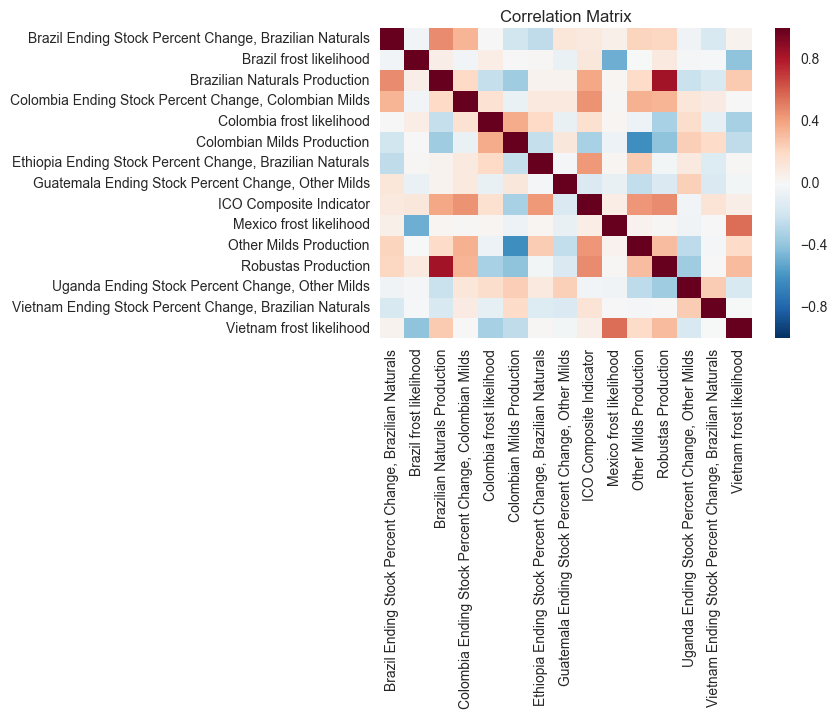

In [12]:
sns.heatmap(test_dataframe.T.drop_duplicates().sort_index().T.corr())
plt.title("Correlation Matrix")
plt.show()


### Showing the distribution of percent changes in ICO Composite Indicator prices

In [13]:
# The percent changes follow a beta distribution

from scipy.stats import beta

ICO_composite_indicator_percent_changes = test_dataframe.ix[1:, "ICO Composite Indicator"].to_frame().pct_change().dropna()
# a, b, loc, scale = beta.fit(ICO_composite_indicator_percent_changes - ICO_composite_indicator_percent_changes.values.min())

def figure_distribution_of_ICO_Composite_Indicator_percent_changes():
    sns.distplot(ICO_composite_indicator_percent_changes.values - ICO_composite_indicator_percent_changes.values.min(), fit = beta, kde = False)
    plt.title("Distribution of ICO Composite Indicator Percent Changes")
    plt.xlabel("ICO Composite Indicator change")
    plt.show()

test_dataframe.ix[1:, "ICO Composite Indicator"].to_frame().pct_change().dropna().describe()


,ICO Composite Indicator
count,322.000000
mean,0.004540
std,0.072377
min,-0.156115
25%,-0.041048
50%,-0.004142
75%,0.039029
max,0.496677


### Principal component analysis

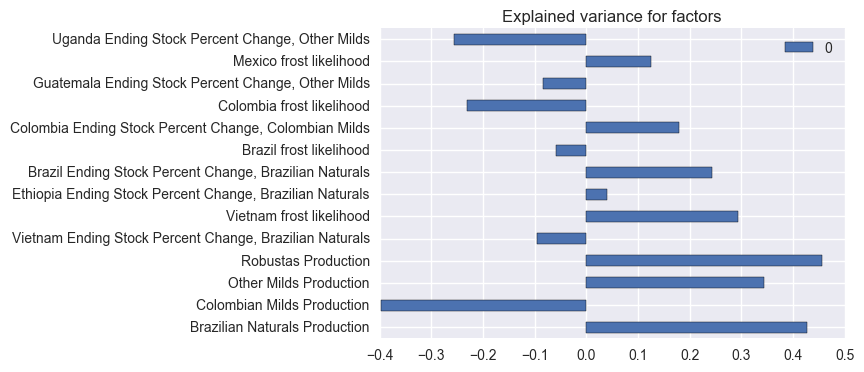

In [14]:
from sklearn.pipeline import Pipeline

pca = PCA()
scaler = StandardScaler()

pca_test_dataframe = test_dataframe[test_dataframe.index.year < 2017].drop("ICO Composite Indicator", axis = 1)
pipe = Pipeline(steps = [("scaler", scaler), ('pca', pca)])

pipe.fit_transform(pca_test_dataframe)

def figure_explained_variance_cumulative_sum():
    plt.plot(np.cumsum(pca.explained_variance_))
    plt.title("Explained Variance for Standardized Features")
    plt.xlabel("Eigenvector index")
    plt.show()


pd.DataFrame(pca.components_[0], index = test_dataframe.drop("ICO Composite Indicator", axis = 1).columns).plot(kind = 'barh')
plt.title("Explained variance for factors")
plt.show()


### Optimized Random Forest Models

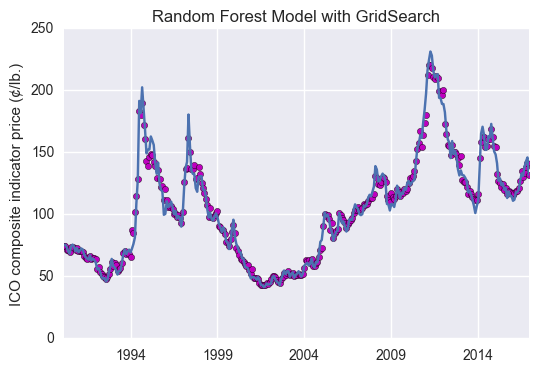

Random forest model score (with GridSearch): 0.9874287723285109


In [15]:
def optimized_random_forest_regression_model(dataframe, months_offset = 1, show_pre_optimized = False, show_all_predictions = True):
    X = dataframe.drop("ICO Composite Indicator", axis = 1).iloc[0:-months_offset]
    y = dataframe.ix[months_offset:, "ICO Composite Indicator"]
    
    random_forest_reg = RandomForestRegressor(n_estimators = 200, max_features = "sqrt")

    if show_pre_optimized == True:
        
        train_X, test_X, train_y, test_y = train_test_split(X, y)
        
        random_forest_reg.fit(train_X, train_y)

        y.plot()
        plt.scatter(x = test_y.index, y = random_forest_reg.predict(test_X), c ="r")
        if show_all_predictions == True:
            plt.scatter(x = y.index, y = random_forest_reg.predict(X), c ="m")
        plt.title("Random Forest Model")
        plt.show()

        print("Random forest model score (pre-GridSearch): {}".format(random_forest_reg.score(X, y)))
        print("Average cross validation score (MSE, pre-GridSearch): {}".format(- cross_val_score(random_forest_reg, X, y, cv = 10).mean()))

    param_grid_for_gridsearch = {"criterion": ["mse", "mae"], 
                                 "max_features": ["auto", "sqrt", "log2"]}
    gridsearch = GridSearchCV(random_forest_reg, param_grid_for_gridsearch, cv = 10)
    gridsearch.fit(X, y)

    y.plot()
    if show_all_predictions == True:
        plt.scatter(x = y.index, y = gridsearch.predict(X), c ="m")
    plt.title("Random Forest Model with GridSearch")
    plt.ylabel("ICO composite indicator price (¢/lb.)")
    plt.show()
    
    print("Random forest model score (with GridSearch): {}".format(gridsearch.score(X, y)))

    
    return gridsearch.best_estimator_
    
random_forest_regressor = optimized_random_forest_regression_model(test_dataframe[test_dataframe.index.year < 2017][1:])


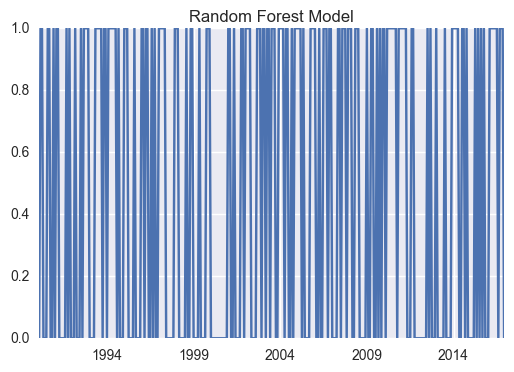

Random forest model score (with GridSearch): 1.0


In [16]:
def random_forest_classifier_with_previous_production_and_ending_stocks(dataframe, months_offset = 1, show_pre_optimized = False, show_all_predictions = True):
    X = dataframe.drop("ICO Composite Indicator", axis = 1).iloc[0:-months_offset]
    y = dataframe.ix[months_offset:, "ICO Composite Indicator"]
    
    y_increase = y.to_frame().pct_change() > 0
    y_increase.columns = ["Positive percent change"]
    y_increase = y_increase["Positive percent change"].map({True: 1, False: 0})
    
    random_forest_classifier = RandomForestClassifier(n_estimators = 200, oob_score = True)
    
    if show_pre_optimized == True:
        train_X, test_X, train_y, test_y = train_test_split(X, y_increase)
        
        random_forest_classifier.fit(train_X, train_y)

        y_increase.plot()
        plt.scatter(x = test_y.index, y = random_forest_classifier.predict(test_X), c = "r")
        if show_all_predictions == True:
            plt.scatter(x = y_increase.index, y = random_forest_classifier.predict(X), c = 'm')
        plt.title("Random Forest Classifier Model")
        plt.show()

        print("Baseline predictor: {}".format(y_increase.mean()))
        print("Random forest classifier model score (pre-GridSearch): {}".format(random_forest_classifier.score(X, y_increase)))
        print("Average cross validation score (MSE, pre-GridSearch): {}".format(- cross_val_score(random_forest_classifier, X, y_increase, cv = 10).mean()))
    
    param_grid_for_gridsearch = {"criterion": ["gini", "entropy"], 
                                 "max_features": [None, "sqrt", "log2"]}
    gridsearch = GridSearchCV(random_forest_classifier, param_grid_for_gridsearch, cv = 10)
    gridsearch.fit(X, y_increase)

    y_increase.plot()
    if show_all_predictions == True:
        plt.scatter(x = y_increase.index, y = gridsearch.predict(X), c ="m")
    plt.title("Random Forest Model")
    plt.show()
    
    print("Random forest model score (with GridSearch): {}".format(gridsearch.score(X, y_increase)))
    
    return gridsearch.best_estimator_
        
random_forest_classifier = random_forest_classifier_with_previous_production_and_ending_stocks(test_dataframe, show_all_predictions = False)


### Predictions

In [17]:
print("Regression prediction for {}: {:.2f} cents per pound".format(
    test_dataframe.iloc[-1, 1:].name.strftime("%m-%d-%Y"), random_forest_regressor.predict(test_dataframe.iloc[-1, 1:].values.reshape(1,-1))[0]
    ))

print("Classification prediction for {}: {:.3f} chance of increase".format(
    test_dataframe.iloc[-1, 1:].name.strftime("%m-%d-%Y"), random_forest_classifier.predict_proba(test_dataframe.iloc[-1, 1:].values.reshape(1,-1))[0][1])
)

Regression prediction for 12-31-2016: 127.29 cents per pound
Classification prediction for 12-31-2016: 0.790 chance of increase


In [18]:
def figure_prices_vs_model_for_2013_to_2016(months_offset = 2):
    test_dataframe.iloc[-48:, 0].plot()
    plt.scatter(x = test_dataframe.iloc[-48:, 0].index.shift(1), y = random_forest_regressor.predict(test_dataframe.iloc[-48:, 1:]), c = 'r')
    plt.title("Optimized Random Forest Regressor Model for 2013 - 2016")
    plt.ylabel("ICO composite indicator price (¢/lb.)")
    plt.show()
    print("Random forest model score: {}".format(random_forest_regressor.score(test_dataframe.iloc[months_offset - 1:, 1:], test_dataframe.iloc[months_offset - 1:, 0])))

def figure_prices_vs_model_for_1990_to_present(months_offset = 2):
    test_dataframe.iloc[:, 0].plot()
    plt.scatter(x = test_dataframe.iloc[months_offset - 1:, 0].index.shift(1), y = random_forest_regressor.predict(test_dataframe.iloc[months_offset - 1:, 1:]), c = 'r')
    plt.title("Optimized Random Forest Regressor Model")
    plt.ylabel("ICO composite indicator price (¢/lb.)")
    plt.show()
    print("Random forest model score: {}".format(random_forest_regressor.score(test_dataframe.iloc[months_offset - 1:, 1:], test_dataframe.iloc[months_offset - 1:, 0])))

In [19]:
test_dataframe.shape

(324, 15)

In [20]:
print("Ratio of unique values in dataframe: {:0.3}".format(np.unique(test_dataframe.values.flatten()).shape[0] / test_dataframe.values.flatten().shape[0]))

Ratio of unique values in dataframe: 0.365


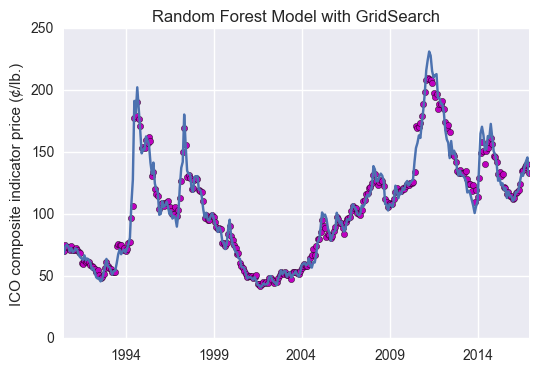

Random forest model score (with GridSearch): 0.9820876627452327


In [21]:
random_forest_regressor_6_month_forecast = optimized_random_forest_regression_model(test_dataframe, months_offset = 6)

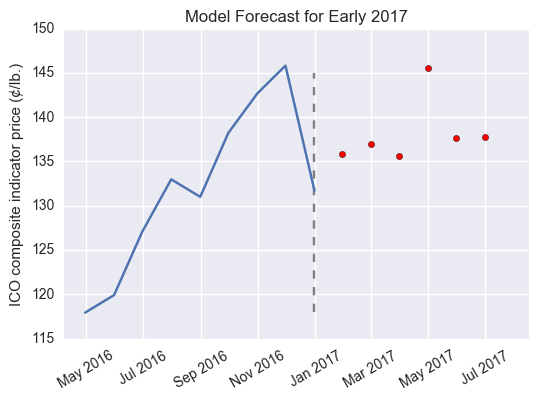

In [22]:
def figure_2017Q1_forecast():
    plt.scatter(x = test_dataframe.iloc[-6:, 0].index + pd.Timedelta(days = int(6 * 365/12)), y = random_forest_regressor_6_month_forecast.predict(test_dataframe.iloc[-6:, 1:]), c = 'r')
    plt.plot(test_dataframe.iloc[-9:, 0])
    plt.vlines(pd.datetime(2016,12,31), 118, 145, linestyles='dashed', colors = 'grey')
    plt.title("Model Forecast for Early 2017")
    plt.xticks(rotation = 30)
    plt.ylabel("ICO composite indicator price (¢/lb.)")
    plt.show()
figure_2017Q1_forecast()
def figure_forecasted_vs_actual_prices_from_2016_to_present():
    pd.DataFrame(random_forest_regressor_6_month_forecast.predict(test_dataframe.iloc[-14:-3, 1:]), 
                 index = test_dataframe.iloc[-14:-3, 0].index + pd.Timedelta(days = int(6 * 365/12)), 
                 columns = ["Forecasted Values"])\
    .merge(pd.DataFrame(np.array([119.91, 127.05, 132.98, 131.00, 138.22, 142.68, 145.82, 131.70, 139.07, 138.174375, np.NaN]), 
                        index = test_dataframe.iloc[-14:-3, 0].index + pd.Timedelta(days = int(6 * 365/12)), 
                        columns = ["Actual Values"]), left_index = True, right_index = True)\
    .plot()
    plt.title("Actual ICO Composite Indicator Prices vs. Predicted Prices")
    plt.vlines(pd.datetime(2016,12,31), 118, 145, linestyles='dashed', colors = 'grey')
    plt.ylabel("ICO composite indicator price (¢/lb.)")
    plt.show()


# Part II: Report


### Introduction

Coffee prices are volatile and difficult to predict. (This is especially true when compared to coffee futures prices, which can be strongly affected by irrational investor speculation.) The USDA's Foreign Agricultural Service issues semi-annual reports on coffee production; among the influences in its reports are previous production volumes, droughts, abnormally warm temperatures, frosts, pest incidences, diseases that affect coffee plants, and labor shortages. However these influences are quantifiable and, to a limited degree, predictable.

Other analyses have focused on production volume to predict global prices. In 1955, Henry Hopp and Richard J. Foote found that global prices between 1882 and 1949 were principally associated with coffee held in storehouses and Brazilian exports. (Hopp, H., and Foote, R. <a href="http://econpapers.repec.org/RePEc:oup:ajagec:v:37:y:1955:i:3:p:429-438">A Statistical Analysis of Factors That Affect Prices of Coffee</a>, American Journal of Agricultural Economics, 1955.) It is likely this relationship still holds, however the market has evolved considerably since then. This analysis will consider past production trends, ending stocks (the amount of coffee held in storehouses before exporting), and frost incidences, for the main coffee producing countries.


### Data

The International Coffee Organization is an intergovernmental body established by the UN in 1963 to improve economic conditions for farmers, strengthen global coffee production, and enable sustainable sector growth. As of February 2017, its 73 member countries represent 98% of global coffee production. 

The ICO composite indicator price is a benchmark for global green coffee prices. (See figure 1.) It is a composite of prices paid for specific categories of coffee at US and EU ports. (The US and EU are the primary coffee importers.) Begining in 2001, each category's prices are weighted to represent its relative share of international coffee trade.  While these weights are adjusted biennially, these values are relatively stable, and the effects of the adjustments could be reasonably ignored. (See figure 2.)

The nature of the coffee market changed in 1989, which created a serious complication for analysis. Under the agreements established in 1963, coffee producing countries were regulated by quotas (renewed every five years) which stabilized prices. However the ICO failed agree to new quotas in 1989, causing the quota system to break down, and the pricing system to convert into a free market. This effectively limited the available target data to the period from 1990 to present, and made this analysis especially susceptible to overfitting.

A large and continual complication came from the ICO grouping countries into traditional categories according to the main coffee species produced, and the primary method of processing. (See the list below.) In all the analysis, care was needed to ensure each country's data was placed in the appropriate grouping.


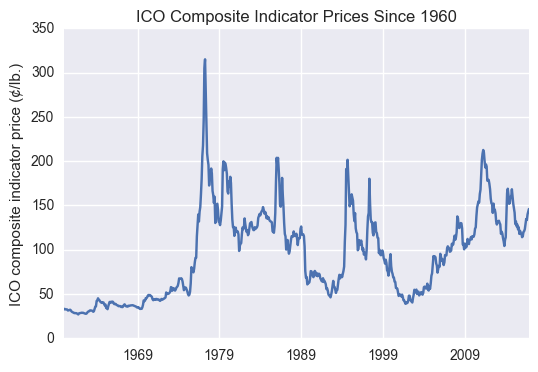

Fig. 1: The ICO composite indicator price over time. Notable events include a devestating frost in Brazil in 1975, 1984 and 1994; the collapse of the quota system in 1989 and the subsequent drop in price; demand exceeding supply in 2011, paired with poor production caused by high rainfall in 2010.


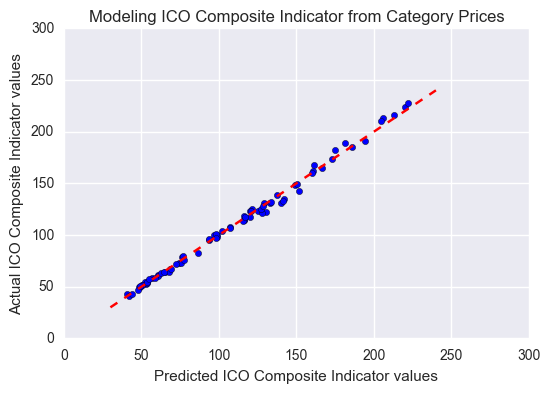

Fig. 2: The ICO composite indicator prices modeled by the producing categories versus actual indicator prices. The strongly linear relationship means that the category weights used to calculate the composite have predictable effects, and can be ignored for this analysis.


In [23]:
figure_ICO_composite_indicator_since_1960()
print("""Fig. 1: The ICO composite indicator price over time. \
Notable events include a devestating frost in Brazil in 1975, 1984 and 1994; \
the collapse of the quota system in 1989 and the subsequent drop in price; \
demand exceeding supply in 2011, paired with poor production caused by high rainfall in 2010.""")

figure_ICO_composite_indicator_modeled_by_ICO_categories()
print("""Fig. 2: The ICO composite indicator prices modeled by the producing categories versus actual indicator prices. \
The strongly linear relationship means that the category weights used to calculate the composite \
have predictable effects, and can be ignored for this analysis.""")


In [24]:
for category in ICO_categories:
    print("{}\n{}\n".format(category, ICO_Composite_Indicator().list_countries_in_ICO_category(category)))


Brazilian Naturals
['Brazil', 'Ethiopia', 'Paraguay', 'Philippines', 'Thailand', 'Timor-Leste', 'Vietnam', 'Yemen']

Colombian Milds
['Colombia', 'Kenya']

Other Milds
['Bolivia', 'Burundi', 'Cameroon', 'Costa Rica', 'Cuba', 'Dem. Rep. of Congo', 'Dominican Republic', 'Ecuador', 'El Salvador', 'Guatemala', 'Haiti', 'Honduras', 'India', 'Indonesia', 'Jamaica', 'Madagascar', 'Malawi', 'Mexico', 'Nepal', 'Nicaragua', 'Panama', 'Papua New Guinea', 'Peru', 'Rwanda', 'Uganda', 'Venezuela', 'Zambia', 'Zimbabwe']

Robustas
['Angola', 'Benin', 'Brazil', 'Burundi', 'Cameroon', 'Central African Republic', 'Congo Rep.', 'Côte d’Ivoire', 'Dem. Rep. of Congo', 'Dominican Republic', 'Ecuador', 'Equatorial Guinea', 'Gabon', 'Ghana', 'Guatemala', 'Guinea', 'Guyana', 'India', 'Indonesia', 'Lao', 'Liberia', 'Madagascar', 'Mexico', 'Nigeria', 'Papua New Guinea', 'People’s Dem. Rep.', 'Philippines', 'Sierra Leone', 'Sri Lanka', 'Tanzania', 'Thailand', 'Timor-Leste', 'Togo', 'Trinidad and Tobago', 'Uganda',

Composite indicator prices were retrieved from the ICO using `pandas` and standard data importing practices. 

Production data was obtained from the USDA's FAS, which includes annual country-specific arabica and robusta productions as well as ending stocks. These can be seen in figure 3 below.

Temperature data was obtained from Berkeley Earth, which is an independent organization that combines and cross-validates global temperature data from 16 datasets. Coffee grows in certain preferred conditions of temperature, rainfall, and elevation, which generally occur in particular ranges of latitude and elevation. This information was used to select data from weather stations located in ideal coffee-growing regions. (See figure 4 below and the accompanying map.) There is no apparent method for quantifying frost risk; for this analysis it was approximated by $\frac{1}{T^2}$, where $T$ is the minimum monthly temperature in degrees Celsius.


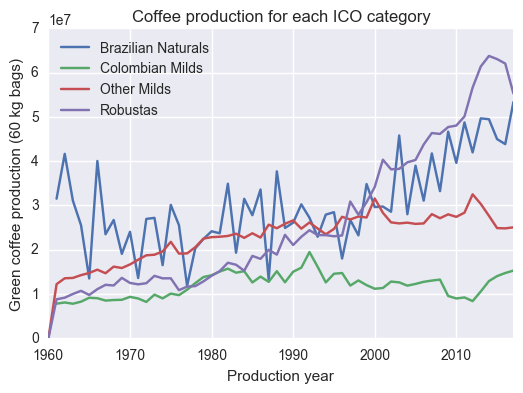

Fig. 3: Annual production is aggregated into ICO categories. Coffee plant produce berries every other year; this biennial effect is most pronounced in Brazil, and therefore in the Brazilian Naturals category.


In [25]:
figure_coffee_production_for_each_ICO_category()
print("""Fig. 3: Annual production is aggregated into ICO categories. \
Coffee plant produce berries every other year; \
this biennial effect is most pronounced in Brazil, and therefore in the Brazilian Naturals category.""")


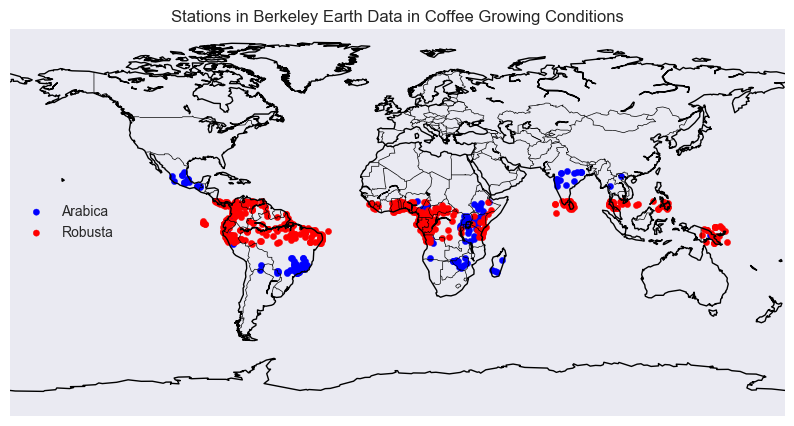

Fig. 4: Weather stations in the Berkeley Earth dataset that are located in ideal coffee-growing conditions. Compare to the following map from Climate.gov.


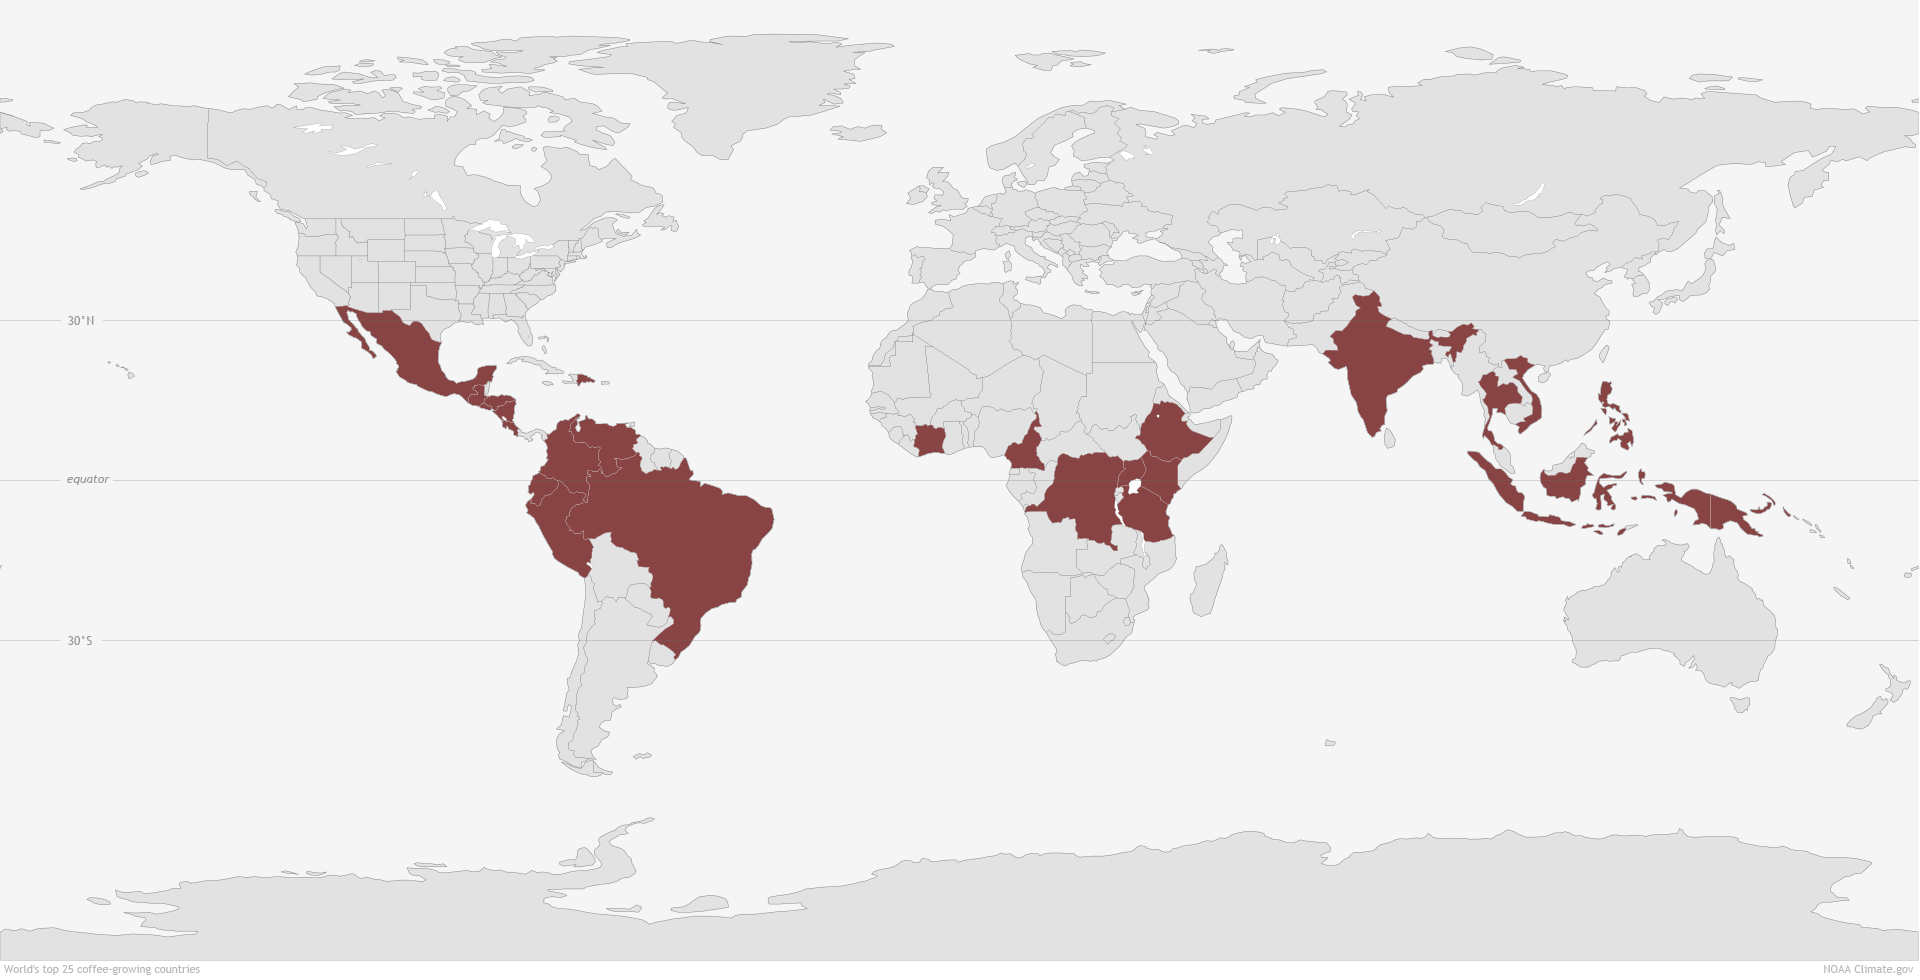

In [26]:
figure_map_of_weather_stations_in_coffee_producing_countries()
print("""Fig. 4: Weather stations in the Berkeley Earth dataset that are located in ideal coffee-growing conditions. \
Compare to the following map from Climate.gov.""")

from IPython.display import Image
Image("https://www.climate.gov/sites/default/files/CoffeeGrowingCountries_large.jpg")

### Procedure

All data was cleaned using `pandas` and standard practices. There were few notable conversions or exclusions of data:
* Temperature data was filtered, as described above.
* The Berkeley Earth temperature data was indexed by decimal fractions. For example: $$\text{January } 25, 2005 = 2005 + (25 - 0.5)/365 =2005.067$$ These values were converted to `pandas`-recognizable datetime formats.
* The FAS production data was backfilled to convert its annual data into monthly data. 

The resulting dataset had 324 observations and approximately 87 features. The number of features was reduced 15 after accounting for the fact that of the 73 member countries in the ICO, a small group accounts for the majority of global production, as is shown in figure 5. 

Principal component analysis was attempted to further reduce the number of features, and decrease the chances of overfitting to the data, however the standardized variations were not easily separable. (See figure 6 below.)


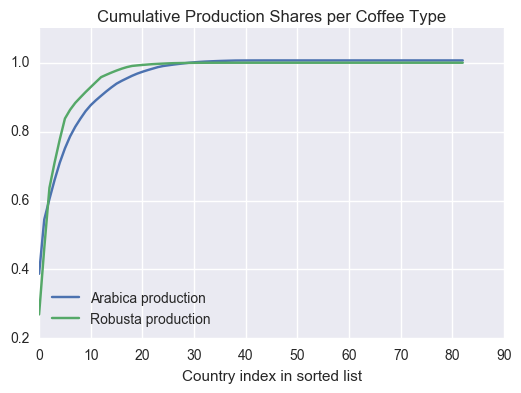

Fig. 5: Cumulative shares of coffee production by country. As can be seen, less than a dozen countries account for more than 90% of global production.


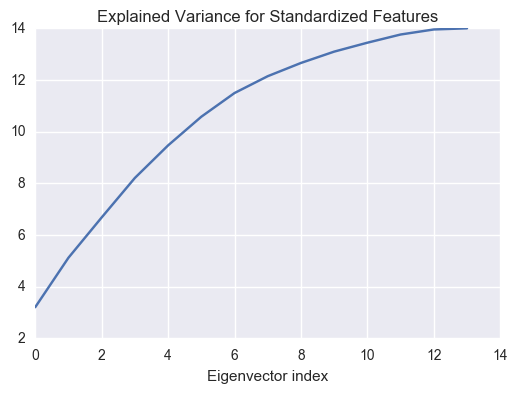

Fig. 6: The cumulative sums of explained variances. The gradual increase of eigenvalues means that no eigenvectors were particularly good at separating the data.



In [27]:
figure_cumulative_production_shares_per_coffee_type_by_country()
print("""Fig. 5: Cumulative shares of coffee production by country. \
As can be seen, less than a dozen countries account for more than 90% of global production.""")

figure_explained_variance_cumulative_sum()
print("""Fig. 6: The cumulative sums of explained variances. \
The gradual increase of eigenvalues means that no eigenvectors were particularly good at separating the data.
""")

The final dataset included information related to Brazil, Colombia, Cote d'Ivoire, Ethiopia, Guatemala, Mexico, Indonesia, Uganda, and Vietnam. It was used to model the ICO composite indicator using a random forest regressor which was optimized with a grid search and cross validation.

### Results and Discussion

The results of modeling are shown in figure 7 below. The model was used to to forecast ICO composite indicator prices for early 2017. (See figure 8.)

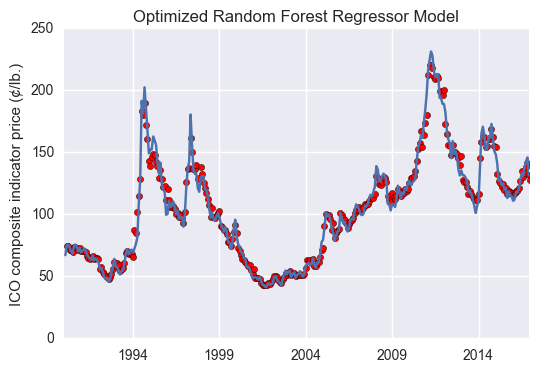

Random forest model score: 0.9585798043817692


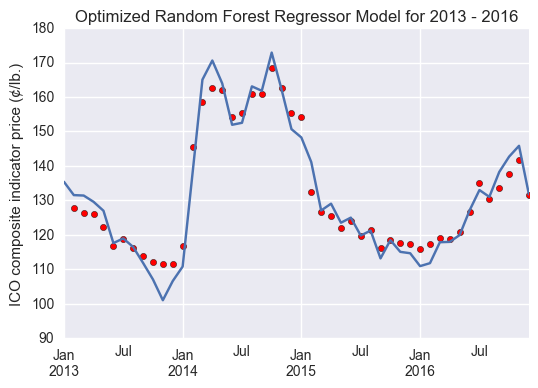

Random forest model score: 0.9585798043817692
Fig. 7: Model (red) compared to actual indicator prices (blue). The score is the cross validation score.


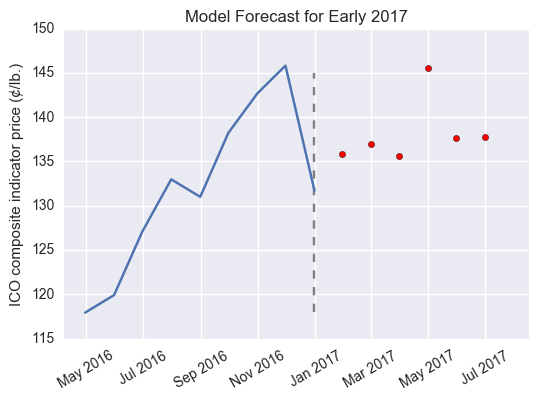

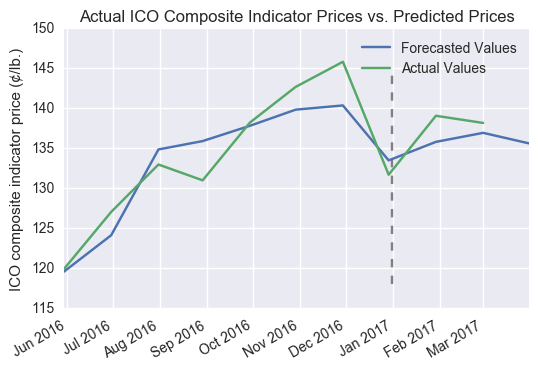

Fig. 8: Predicted indicator prices for early 2017. The information for the ICO composite indicator prices in the bottom plot was manually retrieved from the ICO's website.


In [28]:
figure_prices_vs_model_for_1990_to_present()
figure_prices_vs_model_for_2013_to_2016()
print("""Fig. 7: Model (red) compared to actual indicator prices (blue). The score is the cross validation score.""")

figure_2017Q1_forecast()
figure_forecasted_vs_actual_prices_from_2016_to_present()
print("""Fig. 8: Predicted indicator prices for early 2017. \
The information for the ICO composite indicator prices in the bottom plot was manually retrieved from the ICO's website.""")


The model appears to perform exceptionally well, although this is not likely the case. The bias-variance tradeoff is a major concern when there are relatively few observations per feature, especially in this analysis, where roughly half the data was constructed using backfilled annual data. While measures were taken to mitigate this concern, such as reducing the number of features, using cross validation, and creating forests with large number of trees, the results appear to indicate it is still a major problem.

Another possible interpretation is that this model simply reflects supply and demand economics. Since local consumption (and the percentage diverted to ending stocks) is relatively small, each country's total production correlates very strongly to its supply to the global market. 

### Next Steps

More data is needed to relieve bias-variance concerns. Future analysis could use more sophisticated statistical techniques that specialize in working with small data samples, however a better approach may be to increase the number of observations. The ICO provides subscription-based access to internal data, such as monthly production of its member countries, however it was too expensive for this analysis. (This data may not be completely reliable, since the data are neither validated or balanced.) 

With further research, principal component analysis may be successfully applied to the data used here to address dimensionality concerns.

After increasing the number of observations, there are additional features that would be of interest:
* Precipitation, to indicate drought or flooding.
* Spread of diseases like coffee rust, or pests like the coffee cherry borer.
* The financial conditions for the farmers, as crops may be unharvested or abandoned if it is not an economically feasible enterprise for the growers. This was the case in Colombia in 2008.

Lastly, before any business applications of this (or similar) analysis is realized, prediction intervals must be applied to the forecasts. Methods for calculating these intervals using python are not easily found; indeed, this may be analysis better suited to other programming languages like `R`. A computationally-intensive python approach is possible, however it involves calculating the model error obtained when fitting models to data increasingly in the past of a specific point of interest.

If given more time, I would strive to make these improvements to this analysis, in this order.